In [13]:
# setting up google earth engine
import ee
ee.Authenticate()
ee.Initialize(project='iiith-project')

# study area near patna, bihar for 2019 floods
longitude_min, latitude_min, longitude_max, latitude_max = 85.0, 25.4, 85.6, 25.8
aoi = ee.Geometry.Rectangle([longitude_min, latitude_min, longitude_max, latitude_max])

# time periods - before monsoon and during monsoon
pre_flood_start = '2019-06-01'
pre_flood_end = '2019-06-30'
flood_start = '2019-07-01'
flood_end = '2019-07-31'

In [14]:
# sentinel-1 data for pre-flood
s1_pre_flood = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi).filterDate(pre_flood_start, pre_flood_end) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .select(['VH', 'VV']).median()

# sentinel-1 data during floods
s1_flood = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filterBounds(aoi).filterDate(flood_start, flood_end) \
    .filter(ee.Filter.eq('instrumentMode', 'IW')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .select(['VH', 'VV']).median()

# sentinel-2 optical data with less clouds
s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(aoi).filterDate(flood_start, flood_end) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .select(['B3', 'B4', 'B8', 'B11', 'B12']).median()

In [15]:
# water indices for ganga basin
ndwi = s2.normalizedDifference(['B3', 'B8']).rename('NDWI')
mndwi = s2.normalizedDifference(['B3', 'B11']).rename('MNDWI')
ndvi = s2.normalizedDifference(['B8', 'B4']).rename('NDVI')

# topography affects flood risk
elevation = ee.Image('USGS/SRTMGL1_003').clip(aoi)
slope = ee.Terrain.slope(elevation)

# monsoon rainfall data
precipitation = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate(ee.Date(flood_start).advance(-14, 'day'), flood_end).sum()

In [16]:
# making flood mask
flood_mask = s1_pre_flood.select('VH').subtract(s1_flood.select('VH')).gt(2).rename('flooded')

# all features for ML model
feature_stack = s2.select(['B3', 'B4', 'B8', 'B11', 'B12']) \
    .addBands([ndwi, mndwi, ndvi, elevation, slope, precipitation])
training_img = feature_stack.addBands(flood_mask)

In [17]:
# sampling points for training
sample_points = training_img.stratifiedSample(
    numPoints=5000,
    classBand='flooded',
    region=aoi,
    scale=30,
    seed=42,
    geometries=True
)

# converting to python format
sample_points_fc = sample_points.toList(sample_points.size())
sample_dict = sample_points_fc.getInfo()

In [18]:
# making dataframe like we did in lab
import pandas as pd
data = []
for i in range(len(sample_dict)):
    props = sample_dict[i]['properties']
    data.append([
        props['B3'], props['B4'], props['B8'], props['B11'], props['B12'],
        props['NDWI'], props['MNDWI'], props['NDVI'],
        props['elevation'], props['slope'], props['precipitation'],
        int(props['flooded'])
    ])

df = pd.DataFrame(data, columns=[
    'B3', 'B4', 'B8', 'B11', 'B12', 'NDWI', 'MNDWI', 'NDVI',
    'elevation', 'slope', 'precipitation', 'flooded'
])

In [19]:
# using random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X = df.drop('flooded', axis=1)
y = df['flooded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.8013
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1500
           1       0.81      0.79      0.80      1500

    accuracy                           0.80      3000
   macro avg       0.80      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



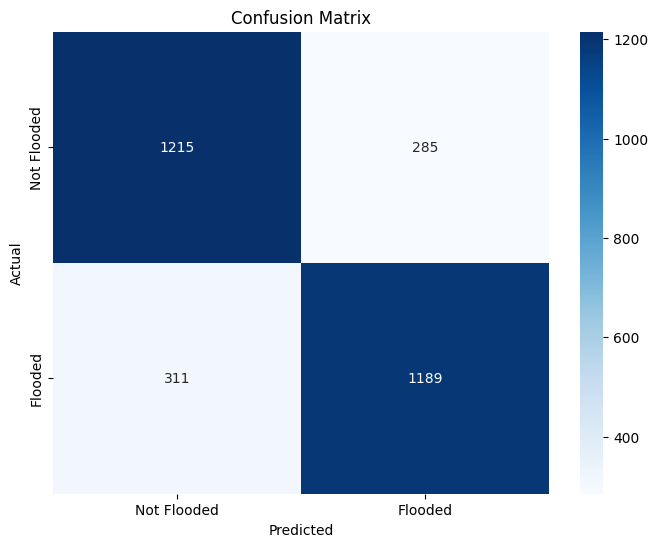

In [20]:
# checking accuracy
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

# confusion matrix for presentation
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Flooded', 'Flooded'],
            yticklabels=['Not Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

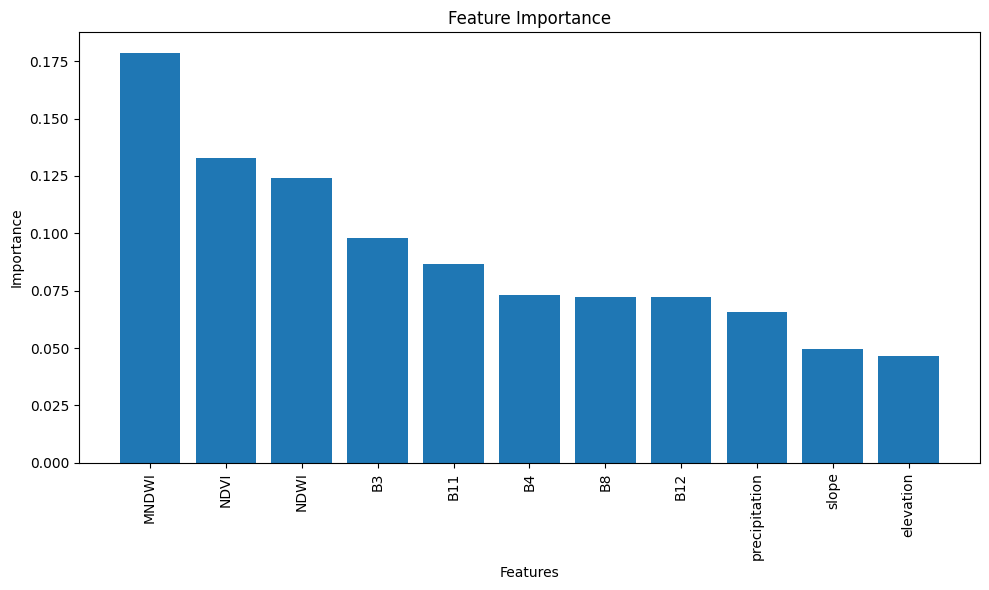

In [21]:
# which bands are most important
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

In [22]:
# classifying whole image using GEE
def classify_image(image):
    input_bands = image.select([
        'B3', 'B4', 'B8', 'B11', 'B12',
        'NDWI', 'MNDWI', 'NDVI',
        'elevation', 'slope', 'precipitation'
    ])
    classifier = ee.Classifier.smileRandomForest(100).train(
        features=sample_points,
        classProperty='flooded',
        inputProperties=input_bands.bandNames()
    )
    return input_bands.classify(classifier)

prediction_map = classify_image(feature_stack)

In [23]:
# displaying map - will show in final report
import geemap
Map = geemap.Map()
Map.centerObject(aoi, 10)
Map.addLayer(prediction_map, {'min': 0, 'max': 1, 'palette': ['white', 'blue']}, 'Flood Prediction')
Map.addLayer(s2.select(['B4', 'B3', 'B8']), {'min': 0, 'max': 3000}, 'True Color', False)
Map

Map(center=[25.60019454402534, 85.30000000000035], controls=(WidgetControl(options=['position', 'transparent_b…